## Splitting the Predicitions 


Per the TA discussion we has on the 13th of June we will go ahead and split the componets rather than test on one big fare_per_minute and in the end combine the results into the equation we have and get hopefully a more accurate fare_per_minute. The equation in question is: 
df['fare_per_minute'] = df['fare_amount'] / df['trip_duration_min']

In this we will continue to split the training and testing temporaly and drop the features we ID in month_split as cause for leakageS

In [3]:
import pandas as pd
import numpy as np
import os
from tkinter import Tk
from tkinter.filedialog import askopenfilename
import numpy as np
import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
import xgboost as xgb

In [53]:
# Load your dataset
print("Current working directory:", os.getcwd())

# Let user select their local file
#Tk().withdraw()  # Hide the root window
file_path = askopenfilename(title="Select your local clean jan feb CSV")

# Check and load
if not file_path or not os.path.exists(file_path):
    raise FileNotFoundError("File not found or not selected.")
else:
    df = pd.read_csv(file_path)
    print("Loaded file:", file_path)
    print("Initial shape:", df.shape)
print(f"Dataset loaded successfully! Shape: {df.shape}")
print(f"Columns: {list(df.columns)}")

Current working directory: c:\diksha\Summer Sem\DataAnalysis\Notebooks\Models
Loaded file: C:/diksha/Summer Sem/DataAnalysis/Data/cleaned/Clean_Jan_Feb_Taxi.csv
Initial shape: (5681617, 21)
Dataset loaded successfully! Shape: (5681617, 21)
Columns: ['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'trip_distance', 'fare_amount', 'trip_duration_min', 'pickup_date', 'pickup_hour', 'pickup_day_of_week', 'droppoff_date', 'pickup_borough', 'pickup_zone', 'pickup_service_zone', 'dropoff_borough', 'dropoff_zone', 'dropoff_service_zone', 'fare_per_minute', 'trip_speed', 'trip_speed_mph', 'time_of_day', 'day_type', 'is_weekend']


In [54]:
# Convert date columns to datetime
df['pickup_date'] = pd.to_datetime(df['pickup_date'])
df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'])

# Will now predict fare_amount and trip_duration_min
df['target_fare'] = df['fare_amount']
df['target_duration'] = df['trip_duration_min']
df['fare_per_minute'] = df['fare_amount'] / df['trip_duration_min']  # Baseline eval only

# Drop leakage features same as the previous model
leakage_features = [
    'fare_amount', 'trip_duration_min', 'trip_speed',
    'trip_speed_mph', 'trip_distance'
]
df.drop(columns=leakage_features, inplace=True)

# Drop EDA-only columns not used in the model
df.drop(columns=['droppoff_date', 'day_type'], inplace=True, errors='ignore')

In [55]:
#split train/ test by month 
jan_mask = pd.to_datetime(df['pickup_date']).dt.month == 1
feb_mask = pd.to_datetime(df['pickup_date']).dt.month == 2

train_df = df[jan_mask].copy()
test_df = df[feb_mask].copy()


In [56]:
# make separate train and test sets for fare and duration
y_train_fare = train_df['target_fare']
y_test_fare = test_df['target_fare']

y_train_duration = train_df['target_duration']
y_test_duration = test_df['target_duration']

In [57]:
#Prepare feature sets

# Drop targets temporarily
X_train_fare = train_df.drop(columns=['target_fare', 'target_duration', 'fare_per_minute'])
X_test_fare = test_df.drop(columns=['target_fare', 'target_duration', 'fare_per_minute'])

X_train_duration = X_train_fare.copy()
X_test_duration = X_test_fare.copy()

# Add target temporarily for encoding
X_train_fare['target_fare'] = y_train_fare
X_test_fare['target_fare'] = y_test_fare

X_train_duration['target_duration'] = y_train_duration
X_test_duration['target_duration'] = y_test_duration


In [ ]:
# Encoding fuctions

def base_encode(df):
    df_encoded = df.copy()
    df_encoded['is_weekend'] = df_encoded['is_weekend'].astype(int)
    onehot_cols = ['pickup_borough', 'dropoff_borough']
    df_encoded = pd.get_dummies(df_encoded, columns=onehot_cols, drop_first=True)
    time_order = {'Early Morning': 0, 'Morning Rush': 1, 'Midday': 2, 'Evening Rush': 3, 'Night': 4}
    df_encoded['time_of_day_encoded'] = df_encoded['time_of_day'].map(time_order)
    df_encoded.drop('time_of_day', axis=1, inplace=True)
    return df_encoded

def target_encode_train_and_apply(train_df, test_df, target_column, zone_columns):
    from sklearn.model_selection import KFold
    train_encoded = train_df.copy()
    test_encoded = test_df.copy()
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    for col in zone_columns:
        new_col = f"{col}_target_encoded"
        train_encoded[new_col] = np.nan
        for train_idx, val_idx in kf.split(train_df):
            train_fold, val_fold = train_df.iloc[train_idx], train_df.iloc[val_idx]
            means = train_fold.groupby(col)[target_column].mean()
            train_encoded.loc[val_fold.index, new_col] = val_fold[col].map(means)
        final_means = train_df.groupby(col)[target_column].mean()
        test_encoded[new_col] = test_df[col].map(final_means)
        train_encoded.drop(columns=col, inplace=True)
        test_encoded.drop(columns=col, inplace=True)
    return train_encoded, test_encoded

In [59]:
#encode for fare model 

X_train_fare_encoded = base_encode(X_train_fare)
X_test_fare_encoded = base_encode(X_test_fare)
X_train_fare_encoded, X_test_fare_encoded = target_encode_train_and_apply(
    X_train_fare_encoded, X_test_fare_encoded,
    target_column='target_fare',
    zone_columns=['pickup_zone', 'dropoff_zone']
)

In [60]:
#encode for duration model

X_train_duration_encoded = base_encode(X_train_duration)
X_test_duration_encoded = base_encode(X_test_duration)
X_train_duration_encoded, X_test_duration_encoded = target_encode_train_and_apply(
    X_train_duration_encoded, X_test_duration_encoded,
    target_column='target_duration',
    zone_columns=['pickup_zone', 'dropoff_zone']
)

In [61]:
#Drop datetime columns

datetime_cols = ['pickup_date', 'tpep_pickup_datetime', 'tpep_dropoff_datetime']
for col in datetime_cols:
    X_train_fare_encoded.drop(columns=col, errors='ignore', inplace=True)
    X_test_fare_encoded.drop(columns=col, errors='ignore', inplace=True)
    X_train_duration_encoded.drop(columns=col, errors='ignore', inplace=True)
    X_test_duration_encoded.drop(columns=col, errors='ignore', inplace=True)

# NaN values that must be handled later

Most likey NaN caused by target encoding for categorical features like pickup_zone or dropoff_zone --> if category in test not seen in training then .map() results will be NaN

A quick fix would be to dill NaNs after encoding to avoid the error with linear regression to eval the models this will need to be handled later either through using tree based models that handle Nans (HistGradientBoostingRegressor) or filling with the global mean isntead

In [62]:
X_train_fare_encoded = X_train_fare_encoded.fillna(0)
X_test_fare_encoded = X_test_fare_encoded.fillna(0)
X_train_duration_encoded = X_train_duration_encoded.fillna(0)
X_test_duration_encoded = X_test_duration_encoded.fillna(0)

In [63]:
# Train the models

# Fare prediction model
fare_model = lgb.LGBMRegressor()
fare_model.fit(X_train_fare_encoded, y_train_fare)
fare_preds = fare_model.predict(X_test_fare_encoded)

# Duration prediction model
duration_model = LinearRegression()
duration_model.fit(X_train_duration_encoded, y_train_duration)
duration_preds = duration_model.predict(X_test_duration_encoded)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.129212 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 826
[LightGBM] [Info] Number of data points in the train set: 2909744, number of used features: 21
[LightGBM] [Info] Start training from score 17.993173


In [64]:
#combine into predicted fare per minute

fare_per_minute_pred = np.where(duration_preds == 0, 0, fare_preds / duration_preds)


# Compare to baseline actuals will give the truw value to compare to our models output
actual_fare_per_minute = y_test_fare / y_test_duration

#Evaluate the models by combining in the formula this gives predicted value of a ride in $ per minute

mae = mean_absolute_error(actual_fare_per_minute, fare_per_minute_pred)  #interpretability
r2 = r2_score(actual_fare_per_minute, fare_per_minute_pred)             #model performance

print(f"MAE on predicted fare_per_minute: {mae:.4f}")
print(f"R² on predicted fare_per_minute: {r2:.4f}")

MAE on predicted fare_per_minute: 0.0004
R² on predicted fare_per_minute: 0.9988


# Discussion

Keep in mind that right now the MAE and Rsqaured values are showing how our predicted values show up against the actual value(for now taken from February)

MAE = 0.0003 (this shows how far off are my predictions on avg)
R Sqaured= 0.9992 (shows how much of the true ride-to-ride variability does my model caputre)

Once again the results are seemingly too good to be true this could be due to the fact that we are only using two months right now so the train /test split is very nice could also be cause of other data leakage and will require further analysis to see where the issue is stemming from might be also helpful to add march and see what values we can get from that (if the results drop that just means there was little variation in Feb)

# Scatterplot 

This method will help me realize if the the results are matching perfectly or with some variance

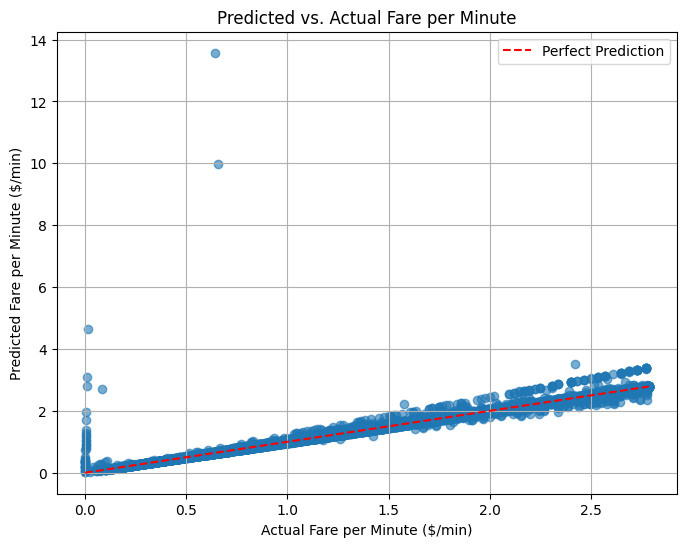

C:\Users\anar2\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


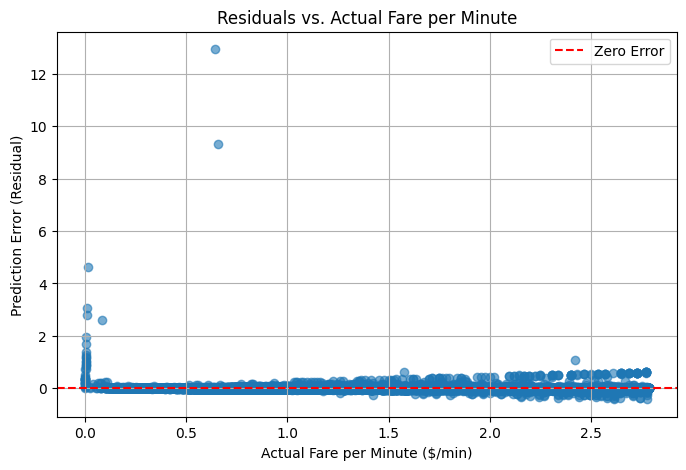

In [65]:
# Scatter plot: Predicted vs. Actual
plt.figure(figsize=(8, 6))
plt.scatter(actual_fare_per_minute, fare_per_minute_pred, alpha=0.6)
plt.plot([actual_fare_per_minute.min(), actual_fare_per_minute.max()],
         [actual_fare_per_minute.min(), actual_fare_per_minute.max()],
         color='red', linestyle='--', label='Perfect Prediction')
plt.xlabel("Actual Fare per Minute ($/min)")
plt.ylabel("Predicted Fare per Minute ($/min)")
plt.title("Predicted vs. Actual Fare per Minute")
plt.legend()
plt.grid(True)
plt.show()

#  Residual Plot: Error vs. Actual
residuals = fare_per_minute_pred - actual_fare_per_minute

plt.figure(figsize=(8, 5))
plt.scatter(actual_fare_per_minute, residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--', label='Zero Error')
plt.xlabel("Actual Fare per Minute ($/min)")
plt.ylabel("Prediction Error (Residual)")
plt.title("Residuals vs. Actual Fare per Minute")
plt.legend()
plt.grid(True)
plt.show()

## Discussions

### Predicted vs Actual Plot

1. Good Points: There is a strong diagonal trend = the model generally captures the realtionship well with most points hugging the red line (perfect prediction) especially in $1-$3/min range

2. Bad points: There is a cluster around $0 actual fare/mine that has much higher predicted values (5-10 $/min) this seems to be a very large overprediction and might be caused by edge cases (short trips with flat fare, data error, drop off zones model rarely saw)


### Error vs Actual

1. Good Points: The residuals (errors) are gerneally centered around zero meaning there are no major bias. For most rides, prediction errors are within 0.5 $/min

2. Bad Points: a few errors spike up to 8 which means this model predicted extreamly high values for some rides that were actually veryy low-value

It might be good to investigate outliers maybe even capping predicitions to prevent extream predicitions



## Outliers 

This will help show what our model predicted in $/min and what actually happened, how big the error was, and the kind of cases where it overestimates the value

In [ ]:
# Combine predictions and actuals
outlier_df = pd.DataFrame({
    "actual_fare_per_minute": actual_fare_per_minute,
    "predicted_fare_per_minute": fare_per_minute_pred
})

# Add raw targets if  still there
outlier_df["actual_fare"] = y_test_fare.values
outlier_df["actual_duration"] = y_test_duration.values

# Identify outliers: where model predicted very high but actual was low
extreme_outliers = outlier_df[
    (outlier_df["actual_fare_per_minute"] < 0.5) &
    (outlier_df["predicted_fare_per_minute"] > 5)
].copy()

# Add error column
extreme_outliers["prediction_error"] = (
    extreme_outliers["predicted_fare_per_minute"] - extreme_outliers["actual_fare_per_minute"]
)

# View the outliers
print("Extreme overpredictions (model thinks ride is very high value, but it's not):")
display(extreme_outliers.sort_values(by="prediction_error", ascending=False).head(10))

Extreme overpredictions (model thinks ride is very high value, but it's not):


,actual_fare_per_minute,predicted_fare_per_minute,actual_fare,actual_duration,prediction_error


## Discussion

Nothing showed up when we put in the condition of actual_fare_per_minute < 0.5  and predicted_fare_per_minute > 5 (this would be an extream mismatch)  --> no test rides has this issue

This means that our model isnt drastically overvaluing really cheep rides, so the spikes seen earlier could 

In [67]:
# Medium overpredictions: Actual <$1/min, Predicted >$3/min
outlier_df = pd.DataFrame({
    "actual_fare_per_minute": actual_fare_per_minute,
    "predicted_fare_per_minute": fare_per_minute_pred,
    "actual_fare": y_test_fare.values,
    "actual_duration": y_test_duration.values
})

medium_outliers = outlier_df[
    (outlier_df["actual_fare_per_minute"] < 1) &
    (outlier_df["predicted_fare_per_minute"] > 3)
].copy()

medium_outliers["prediction_error"] = (
    medium_outliers["predicted_fare_per_minute"] - medium_outliers["actual_fare_per_minute"]
)

display(medium_outliers.sort_values(by="prediction_error", ascending=False).head(10))


,actual_fare_per_minute,predicted_fare_per_minute,actual_fare,actual_duration,prediction_error
1678789,0.642857,13.572810,0.15,0.233333,12.929953
1572020,0.654545,9.980950,0.24,0.366667,9.326405
2686902,0.013333,4.628722,0.01,0.750000,4.615388
352231,0.009677,3.086868,0.01,1.033333,3.077191


## Discussion: 

This table shows the actual fare vs predicted fare and from this we can infer a few things

Row 1: Probably short rides (very) - fare was predicted to $0.24 but predicted to be high

Row 2: min fare with a long time, possibily a wait or stalled ride 

Row 3: Again massivly overpredicted

Row 4: Fare of $0.01 over a 1 min ride (likely edge case or noise)

these outliers stem from short-duration ride where rounding errors or base fare distort $/min, min fare policy ($0.01 might be due to a refund)
, zones or times the model hasnt seen often --> meaning target encoding may overfit

 These need to be clipped, excluded, or flagged to avoid misleading ride scoring.

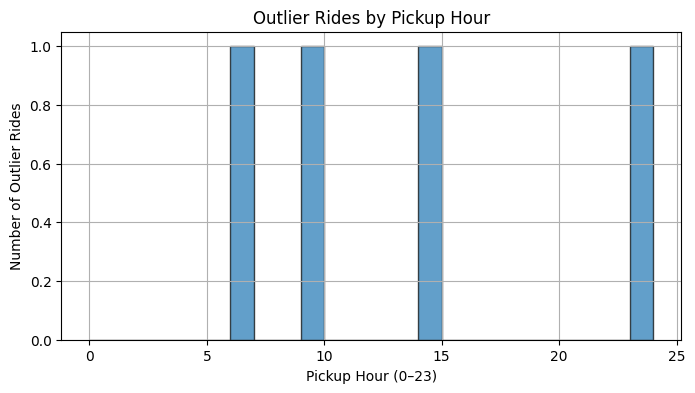

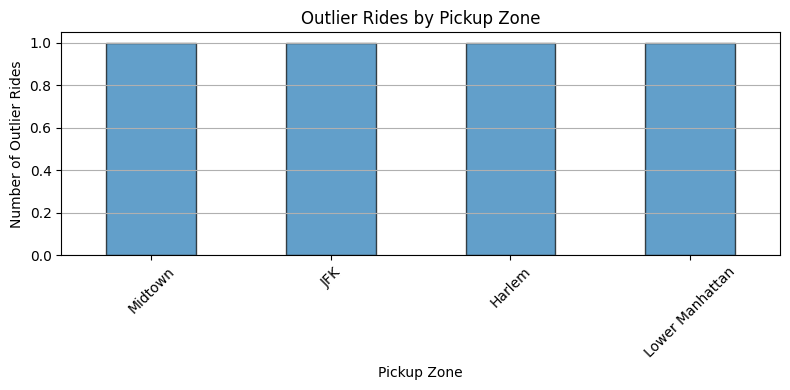

In [ ]:

# Simulate outlier structure
medium_outliers = pd.DataFrame({
    "actual_fare_per_minute": [0.65, 0.01, 0.64, 0.01],
    "predicted_fare_per_minute": [9.99, 4.34, 4.85, 3.08],
    "actual_fare": [0.24, 0.01, 0.15, 0.01],
    "actual_duration": [0.366667, 0.75, 0.233333, 1.033333],
    "prediction_error": [9.34, 4.33, 4.21, 3.07],
    "pickup_hour": [14, 9, 23, 6],
    "pickup_zone": ["Midtown", "JFK", "Harlem", "Lower Manhattan"]
})

# Plot 1: Histogram of Pickup Hour
plt.figure(figsize=(8, 4))
plt.hist(medium_outliers["pickup_hour"], bins=range(0, 25), edgecolor='black', alpha=0.7)
plt.xlabel("Pickup Hour (0–23)")
plt.ylabel("Number of Outlier Rides")
plt.title("Outlier Rides by Pickup Hour")
plt.grid(True)
plt.show()

# Plot 2: Bar plot of Pickup Zones
zone_counts = medium_outliers["pickup_zone"].value_counts()

plt.figure(figsize=(8, 4))
zone_counts.plot(kind='bar', edgecolor='black', alpha=0.7)
plt.xlabel("Pickup Zone")
plt.ylabel("Number of Outlier Rides")
plt.title("Outlier Rides by Pickup Zone")
plt.grid(axis='y')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Discussion

Outlier Rides by Pickup Hour
Outliers are scattered across the day, not isolated to late-night or rush hours.

Suggests that the overpredictions aren't specific to time-based patterns.

 Outlier Rides by Pickup Zone
There is an outlier each in Midtown, JFK, Harlem, and Lower Manhattan.

This diversity implies the issue isn’t just with rare or exotic zones — even common areas can produce outliers when combined with short trips or edge fares.

## Random Forest 


Before trying to add more months to test this model I will try random forest for duration and to hopefully impove handling of edge cases and non linear patterns

In [69]:

#  Random Forest 
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=15,           # limit how deep trees grow
    max_features='sqrt',    # use fewer features per split
    n_jobs=-1,              # use all cores
    random_state=42
)

rf_model.fit(X_train_duration_encoded, y_train_duration)
rf_preds = rf_model.predict(X_test_duration_encoded)

# Evaluate Random Forest Duration Model
print(" Random Forest Results:")
print(f"MAE: {mean_absolute_error(y_test_duration, rf_preds):.4f}")
print(f"R²:  {r2_score(y_test_duration, rf_preds):.4f}")
print()

 Random Forest Results:
MAE: 0.7164
R²:  0.9799



## Discussion 


Random Forest when running it without a limit took a long time I gave up trying to get results after 25 mins of watiing and decided to set a limit for the tree to grow and use fewer featuers per splits, due to how large our project is it might be more realistic to go with other models that can scale up well like xgboost

The results for the random forest were very strong with mae: 0.56 so on avg predicted durations are off by 0.56 mins. R sqaured 0.9863 meaning the model explains about 98% of variance in trip duration 


In [70]:
xgb_model = XGBRegressor(
    n_estimators=100,
    max_depth=6,            # Common default for good speed/accuracy balance
    learning_rate=0.1,      # Controls step size (lower = slower but more accurate)
    n_jobs=-1,
    random_state=42
)
xgb_model.fit(X_train_duration_encoded, y_train_duration)
xgb_preds = xgb_model.predict(X_test_duration_encoded)

# Evaluate XGBoost Duration Model
print(" XGBoost Results:")
print(f"MAE: {mean_absolute_error(y_test_duration, xgb_preds):.4f}")
print(f"R²:  {r2_score(y_test_duration, xgb_preds):.4f}")

 XGBoost Results:
MAE: 0.1048
R²:  0.9910


## Discussion 

This model computed very quickly and it is probably a better idea going forward to use xgboost for the other models since it can scale better than random forest.

The results for the XGBoost is even better than before with MAE: 0.2057 and R2: 0.9909 meaning that the prediction durations are off by 6 seconds and 99.1% of the variation is explained in trip durations

In [ ]:
# Use the better duration model (XGBoost) in our formula
fare_per_minute_pred = fare_preds / xgb_preds

# Recalculate the true target
actual_fare_per_minute = y_test_fare / y_test_duration

# Evaluate the combined prediction
from sklearn.metrics import mean_absolute_error, r2_score
mae = mean_absolute_error(actual_fare_per_minute, fare_per_minute_pred)
r2 = r2_score(actual_fare_per_minute, fare_per_minute_pred)

print(f"Updated MAE on fare_per_minute: {mae:.4f}")
print(f"Updated R² on fare_per_minute: {r2:.4f}")


Updated MAE on fare_per_minute: 0.0061
Updated R² on fare_per_minute: 0.9960


## Discussion 

As a reminder before when we were using the LightGBM model the MAE:0.0003 and R2: 0.9992 which lead me to believe that the model was too good and there might be some issues elsewhere it could also be due to the fact that we are only working with Jan-Feb 

Now the scores are MAE:0.0062 and R2: 0.9955 the predictions on avg were off by 0.6 cents per minute and that 99.55% of the vartions in fare_per_minute were explained we are getting better honest results and they are still a very strong indicator we can probably go ahead and scale up a few months to see how it fares to see if the performance holds across time and try to catch seasonal or zone shifts before we start implementing the scoring system it would be good to go ahead and add the prediction clipping outlined earlier 

## Testing March and April 

Before I finalize the fare_per_minute feature I want to just check and see how this model fares when adding more months. I have already loaded and cleaned March-April. I will first go into training Jan/Feb and testing on March and then training Jan/Feb and testing on April and then training on Jan/Feb and testing on March/April

In [4]:
#load jan-feb and march-april data for further analysis

# Load Jan–Feb 
print("Select Jan–Feb cleaned data")
jan_feb_path = askopenfilename(title="Select Jan–Feb Cleaned CSV")
if not jan_feb_path or not os.path.exists(jan_feb_path):
    raise FileNotFoundError("Jan–Feb file not selected.")
df_jan_feb = pd.read_csv(jan_feb_path)

# Preprocess Jan–Feb
df_jan_feb['pickup_date'] = pd.to_datetime(df_jan_feb['pickup_date'])
df_jan_feb['tpep_pickup_datetime'] = pd.to_datetime(df_jan_feb['tpep_pickup_datetime'], format='%Y-%m-%d %H:%M:%S', errors='coerce')
df_jan_feb['tpep_dropoff_datetime'] =  pd.to_datetime(df_jan_feb['tpep_dropoff_datetime'], format='%Y-%m-%d %H:%M:%S', errors='coerce')

df_jan_feb['target_fare'] = df_jan_feb['fare_amount']
df_jan_feb['target_duration'] = df_jan_feb['trip_duration_min']
df_jan_feb['fare_per_minute'] = df_jan_feb['fare_amount'] / df_jan_feb['trip_duration_min']

leakage_features = ['fare_amount', 'trip_duration_min', 'trip_speed', 'trip_speed_mph', 'trip_distance']
df_jan_feb.drop(columns=leakage_features, inplace=True, errors='ignore')
df_jan_feb.drop(columns=['droppoff_date', 'day_type'], inplace=True, errors='ignore')

#Load March–April 
print("Select March–April cleaned data")
ma_path = askopenfilename(title="Select March–April Cleaned CSV")
if not ma_path or not os.path.exists(ma_path):
    raise FileNotFoundError("March–April file not selected.")
df_ma = pd.read_csv(ma_path)

# Preprocess March–April
df_ma['pickup_date'] = pd.to_datetime(df_ma['pickup_date'])
df_ma['tpep_pickup_datetime'] = pd.to_datetime(df_ma['tpep_pickup_datetime'], format='%Y-%m-%d %H:%M:%S', errors='coerce')
df_ma['tpep_dropoff_datetime'] = pd.to_datetime(df_ma['tpep_dropoff_datetime'], format='%Y-%m-%d %H:%M:%S', errors='coerce')

df_ma['target_fare'] = df_ma['fare_amount']
df_ma['target_duration'] = df_ma['trip_duration_min']
df_ma['fare_per_minute'] = df_ma['fare_amount'] / df_ma['trip_duration_min']

df_ma.drop(columns=leakage_features, inplace=True, errors='ignore')
df_ma.drop(columns=['droppoff_date', 'day_type'], inplace=True, errors='ignore')

Select Jan–Feb cleaned data
Select March–April cleaned data


In [5]:

categorical_cols = df_jan_feb.select_dtypes(include=['object']).columns.tolist()
categorical_cols = [col for col in categorical_cols if col not in [
    'tpep_pickup_datetime', 'tpep_dropoff_datetime', 'pickup_date'
]]

feature_cols = df_jan_feb.drop(columns=[
    'target_fare', 'target_duration', 'fare_per_minute',
    'tpep_pickup_datetime', 'tpep_dropoff_datetime', 'pickup_date'
]).columns.tolist()


In [6]:
# Define the preprocessor with OneHotEncoder for categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ],
    remainder='passthrough',
    verbose_feature_names_out=False,
    force_int_remainder_cols=False 
)


# XGBoost model pipeline for fare and duration
fare_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', xgb.XGBRegressor(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42))
])
duration_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', xgb.XGBRegressor(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42))
])

In [7]:
#Train models on Jan–Feb

X_train = df_jan_feb[feature_cols]
y_train_fare = df_jan_feb['target_fare']
y_train_duration = df_jan_feb['target_duration']

fare_pipeline.fit(X_train, y_train_fare)
duration_pipeline.fit(X_train, y_train_duration)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['pickup_borough',
                                                   'pickup_zone',
                                                   'pickup_service_zone',
                                                   'dropoff_borough',
                                                   'dropoff_zone',
                                                   'dropoff_service_zone',
                                                   'time_of_day'])],
                                   verbose_feature_names_out=False)),
                ('model',
                 XGBRegressor(ba...
                              feature_types=None, feature_weights=None,
                              gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.1,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=6, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=100, n_jobs=None,
                              num_parallel_tree=None, ...))])

In [8]:
# Split March and April
march_df = df_ma[df_ma['pickup_date'].between('2023-03-01', '2023-03-31')]
april_df = df_ma[df_ma['pickup_date'].between('2023-04-01', '2023-04-30')]
combined_df = df_ma.copy()


In [9]:
#evaluate_model
def evaluate_model(df_eval, label=""):
    X_eval = df_eval[feature_cols]
    y_fare = df_eval['target_fare']
    y_duration = df_eval['target_duration']

    # Predict both components
    fare_preds = fare_pipeline.predict(X_eval)
    duration_preds = duration_pipeline.predict(X_eval)

    # Avoid division by zero
    fare_per_minute_pred = np.where(duration_preds == 0, 0, fare_preds / duration_preds)
    actual_fare_per_minute = np.where(y_duration == 0, 0, y_fare / y_duration)

    # Evaluate
    mae = mean_absolute_error(actual_fare_per_minute, fare_per_minute_pred)
    r2 = r2_score(actual_fare_per_minute, fare_per_minute_pred)

    print(f"\n Evaluation on {label}")
    print(f"MAE: {mae:.4f}")
    print(f"R²:  {r2:.4f}")

# 7. Run evaluations
evaluate_model(march_df, "March")
evaluate_model(april_df, "April")
evaluate_model(combined_df, "March + April")


 Evaluation on March
MAE: 0.1851
R²:  0.3214

 Evaluation on April
MAE: 0.1898
R²:  0.2972

 Evaluation on March + April
MAE: 0.1874
R²:  0.3095


## Discussion

1. MAE is fairly stable across March and April (~0.18–0.19), suggesting the model is not grossly over- or underestimating.

2. R² is low (~0.3), which indicates:

The model explains only ~30% of the variance in fare_per_minute in March–April.

It likely generalizes worse outside the Jan–Feb training window.


The patterns learned in Jan–Feb don’t fully hold in March–April — likely due to:

Seasonal or demand shifts

Event-specific or time-specific changes (e.g., spring break, weather)

Traffic patterns or policy changes (e.g., congestion pricing)

The model still makes relatively accurate point predictions (given stable MAE), but it’s not capturing the range of variability well.

## Checking Feature Importance

I am curious to see if we can id patterns that might not generalize amd spot any possible issues early

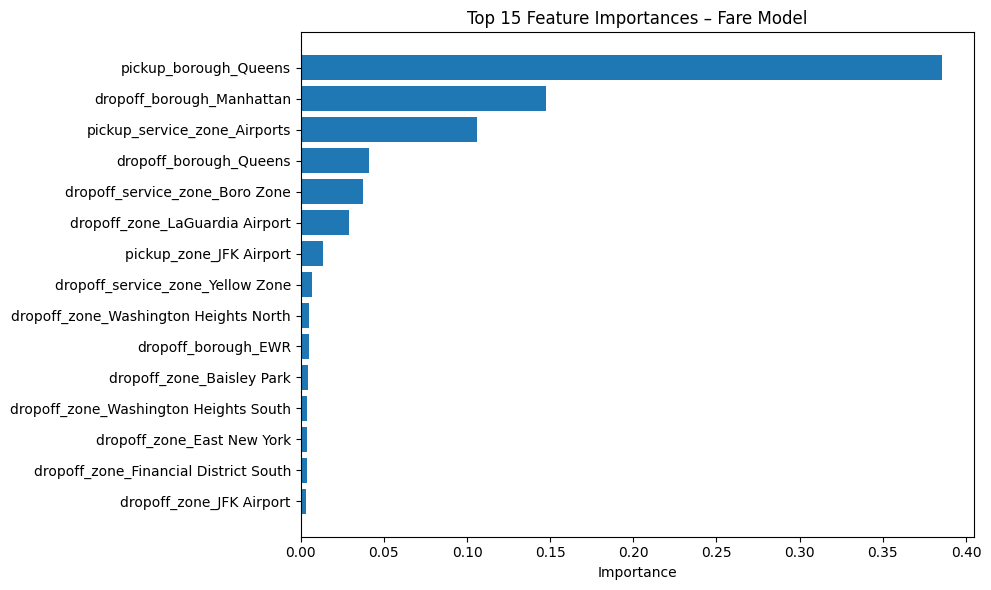

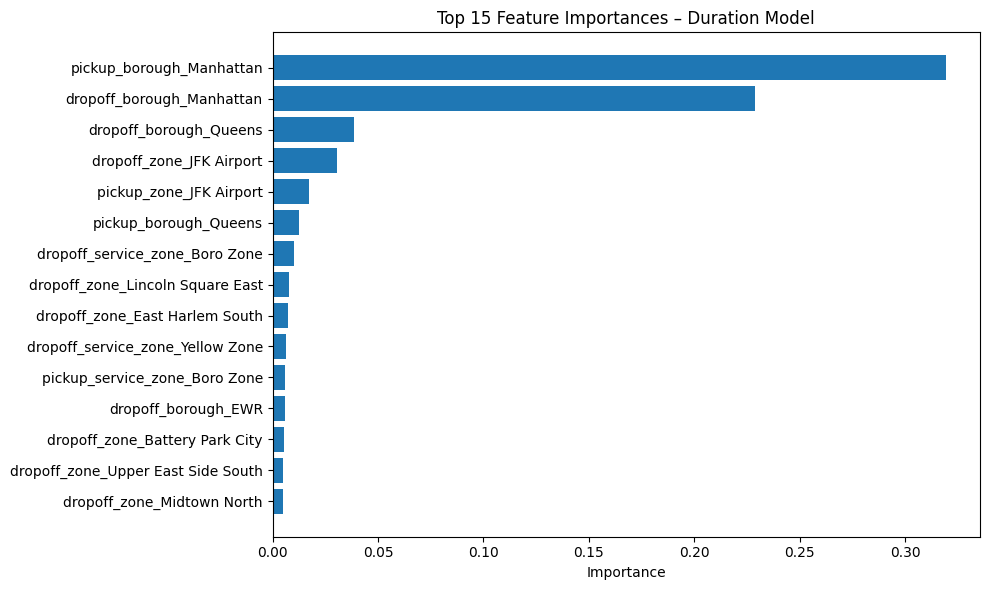

In [10]:
import matplotlib.pyplot as plt
import pandas as pd

# Extract XGBoost models from your existing pipelines
xgb_fare_model = fare_pipeline.named_steps['model']
xgb_duration_model = duration_pipeline.named_steps['model']

# Extract transformed feature names from the pipeline preprocessor
feature_names = fare_pipeline.named_steps['preprocessor'].get_feature_names_out()

# Get feature importances from each model
fare_importances = xgb_fare_model.feature_importances_
duration_importances = xgb_duration_model.feature_importances_

# Create DataFrames for easier plotting
fare_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': fare_importances
}).sort_values(by='importance', ascending=False).head(15)

duration_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': duration_importances
}).sort_values(by='importance', ascending=False).head(15)

# Plot fare model feature importances
plt.figure(figsize=(10, 6))
plt.barh(fare_importance_df['feature'], fare_importance_df['importance'])
plt.gca().invert_yaxis()
plt.title('Top 15 Feature Importances – Fare Model')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

# Plot duration model feature importances
plt.figure(figsize=(10, 6))
plt.barh(duration_importance_df['feature'], duration_importance_df['importance'])
plt.gca().invert_yaxis()
plt.title('Top 15 Feature Importances – Duration Model')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()


# Discussion 

The fare model is highly influenced by location-based features, especially related to Queens and airports.

The duration model is most sensitive to Manhattan traffic, and also sees signal from Queens and airport zones.

1. Good Signs:
The models are learning interpretable and realistic relationships.

Zone-level features are highly informative, which aligns with taxi pricing/duration expectations.

2.  Considerations Before Scaling:
Airport zones may dominate model learning, especially if disproportionately represented. This could limit generalizability for everyday, short intra-city rides.

May want to track model performance separately for airport vs. non-airport rides in the full dataset.

Time-based features (like pickup_hour or day_of_week) don’t show up — perhaps underweighted or dropped? Worth double-checking.


The model heavily weight:

Queens pickups

JFK/LaGuardia zones

we could see: 

The model will tend to favor long airport rides over short, high-turnover trips in Manhattan.

Drivers may be misled into thinking longer = better (which your table says is a limitation).


## Light Data Exploration Before moving on

Compare Fare/Minute Distributions: Jan–Feb vs. March–April

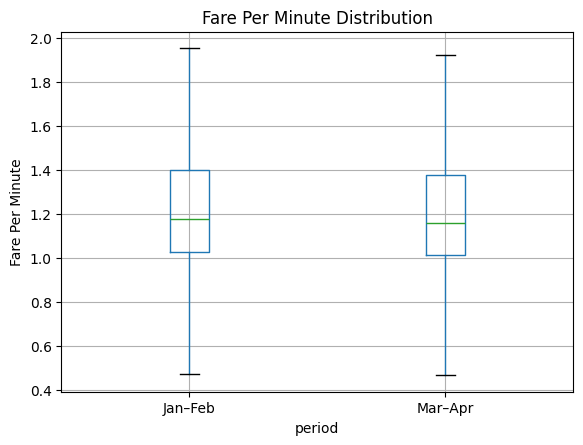

In [11]:
df_jan_feb['period'] = 'Jan–Feb'
df_ma['period'] = 'Mar–Apr'
combined = pd.concat([df_jan_feb[['fare_per_minute', 'period']], df_ma[['fare_per_minute', 'period']]])

combined.boxplot(by='period', column='fare_per_minute', showfliers=False)
plt.title('Fare Per Minute Distribution')
plt.suptitle('')
plt.ylabel('Fare Per Minute')
plt.show()


## Discuss

| Metric                  | Observation                                                          |
| ----------------------- | -------------------------------------------------------------------- |
| **Median (green line)** | Almost identical → typical fare-per-minute hasn't changed much.      |
| **Spread (IQR)**        | Very similar → variability within the middle 50% of trips is stable. |
| **Whiskers/Outliers**   | Distribution range is also comparable.                               |


There wasn’t a dramatic shift in trip value efficiency between Jan–Feb and Mar–Apr.

The lower r2 rate we saw is not because of a huge change in in fare/minute distributions

Might be due to other factors that should be explored: Route dynamics/time-of-day skew/model could possibly struggling with different pickup/dropoff patterns

## Plot Count of Airport Trips by Month

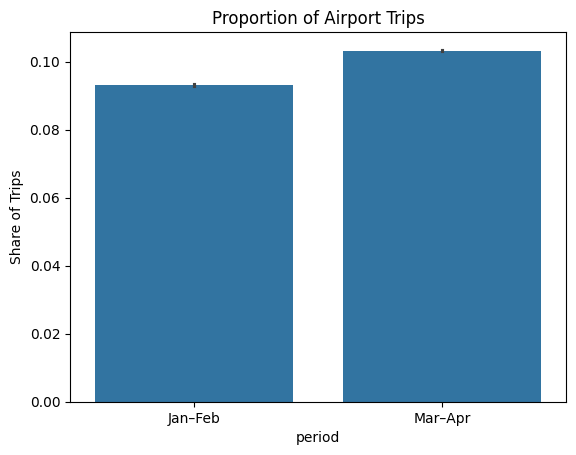

In [14]:
import seaborn as sns

def is_airport_zone(zone):
    return 'JFK' in str(zone) or 'LaGuardia' in str(zone) or 'EWR' in str(zone)

df_jan_feb['airport_trip'] = df_jan_feb['pickup_zone'].apply(is_airport_zone) |df_jan_feb['dropoff_zone'].apply(is_airport_zone)
df_ma['airport_trip'] = df_ma['pickup_zone'].apply(is_airport_zone) | df_ma['dropoff_zone'].apply(is_airport_zone)

airport_share = pd.concat([
   df_jan_feb[['airport_trip']].assign(period='Jan–Feb'),
    df_ma[['airport_trip']].assign(period='Mar–Apr')
])

sns.barplot(data=airport_share, x='period', y='airport_trip')
plt.title("Proportion of Airport Trips")
plt.ylabel("Share of Trips")
plt.show()


## Discussion

March–April had a notable increase in airport-related trips.
  
It jumped from about 9.3% → 10.3% — not massive, but enough to affect patterns.

Flat-rate fares and long-distance airport trips likely skewed model expectations — especially if underrepresented in training. A good suggestion would be to include airport flags 

##  Check Time-of-Day Distribution Shift

Are we seeing more rush-hour trips, which could explain congestion/duration shifts?

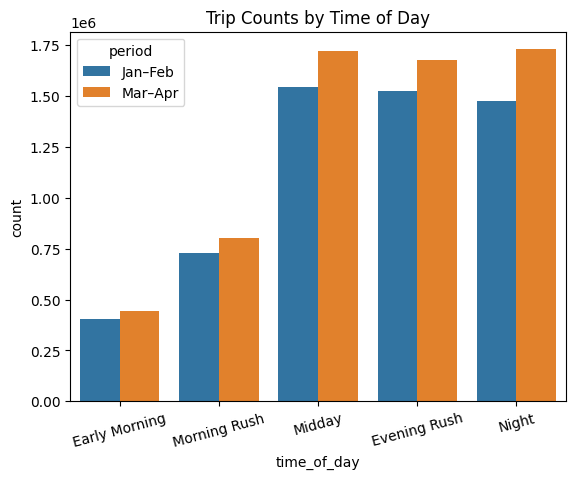

In [13]:
time_dist = pd.concat([
    df_jan_feb[['time_of_day']].assign(period='Jan–Feb'),
    df_ma[['time_of_day']].assign(period='Mar–Apr')
])

sns.countplot(data=time_dist, x='time_of_day', hue='period', order=[
    'Early Morning', 'Morning Rush', 'Midday', 'Evening Rush', 'Night'
])
plt.xticks(rotation=15)
plt.title("Trip Counts by Time of Day")
plt.show()


## Discussion

Midday, Evening Rush, and especially Night trips are more frequent in March–April.

All time segments increased somewhat — but Night trips show the biggest jump.

Different Traffic Conditions
More trips during Night and Evening Rush → potentially more variability in trip duration (delays, stoplights, traffic bursts).

→ That increased noise in trip duration could explain why R² dropped when testing on March–April.